In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import pickle

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')


- Data Exploration
- Datasets 
  - [llm-detect-ai-generated-text](https://www.kaggle.com/competitions/llm-detect-ai-generated-text)
  - [additionnal data : daigt-v2-train-dataset](https://www.kaggle.com/datasets/thedrcat/daigt-v2-train-dataset)

- Cleaning
- Pre-Processing
- Modeling
- Saving

In [15]:
official_texts_df = pd.read_csv("../../raw_data/llm-detect-ai-generated-text/train_essays.csv")
official_texts_df

drcat_02_texts_df = pd.read_csv("../../raw_data/daigt-v2-train-dataset/train_v2_drcat_02.csv")
drcat_02_texts_df

,text,label,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False
...,...,...,...,...,...
44863,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44864,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44865,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True
44866,"Dear Senator,\n\nI am writing to you today to ...",1,Does the electoral college work?,kingki19_palm,True


In [32]:
genai_texts_df = pd.DataFrame(drcat_02_texts_df['text'].sample(1000))
genai_texts_df["generated"] = 1

In [29]:
official_non_generated_texts_df = official_texts_df[official_texts_df["generated"] == 0].sample(1000)
official_non_generated_texts_df = official_non_generated_texts_df[['text', 'generated']]
official_non_generated_texts_df.head(2)

,text,generated
139,Some of the advantages of limiting car usage i...,0
395,We need to keep the Electoral College because ...,0


In [34]:
texts_df = pd.concat(objs=[genai_texts_df, official_non_generated_texts_df])
texts_df

,text,generated
34524,When it comes to making important decisions an...,1
24500,When someone does not know or is confused abou...,1
107,"Required Essay: Phones & Driving\n\nToday, the...",1
32951,"Ugh, do I really have to write another essay? ...",1
34066,"Dear Principal Smith,\n\nI am writing to you r...",1
...,...,...
1271,"Dear Florida Senator, I am here to tell you ab...",0
862,Abolishing the Electoral College sounds like a...,0
99,"Car alarms, car horns, and engines are basical...",0
1172,"Dear Senator, I strongly suggest that you keep...",0


In [44]:
def text_lenght(text):
    return len(text)

def average_sentences(text):
    return len(text.split("."))

texts_df['text_lenght'] = texts_df['text'].apply(text_lenght)
texts_df['sentences_count'] = texts_df['text'].apply(average_sentences)
texts_df.head(2)


,text,generated,text_lenght,sentences_count
34524,When it comes to making important decisions an...,1,1627,12
24500,When someone does not know or is confused abou...,1,2495,24


In [45]:
texts_df.groupby(['generated']).mean(text_lenght)

,text_lenght,sentences_count
generated,,
0,3169.890,30.017
1,2189.034,20.387


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

X = texts_df[['text_lenght', 'sentences_count']]
y = texts_df['generated']

model = LogisticRegression()

cv_results = cross_validate(model, X, y, cv=10)

print(cv_results['test_score'])

cv_results['test_score'].mean()


[0.72  0.745 0.73  0.7   0.8   0.695 0.71  0.755 0.74  0.74 ]


np.float64(0.7335)

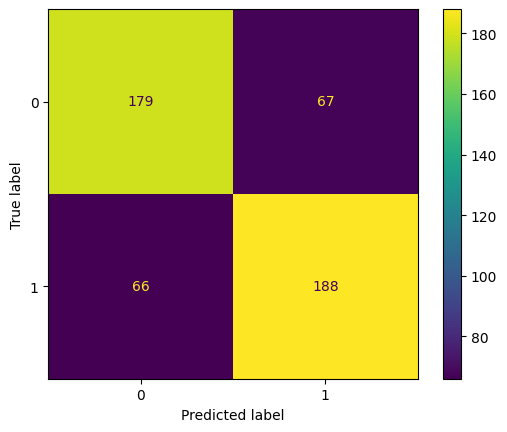

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(
y_test, y_pred)
plt.show()

zsh:1: command not found: gh api user | jq -r '.login'


In [51]:
# Save model

# save the model to disk
filename = '../../detect_ai_content/models/leverdewagon/finalized_genai_text_detection_model.pickle'
pickle.dump(model, open(filename, 'wb'))